Make sure you fill your name and NetID below:

In [ ]:
NAME = "Shyam Patel"
NET_ID = "spp128"

---

---
# Assignment 3: Reinforcement Learning

In this assignment, you will implement a few reinforcement learning algorithms:

1. Deep Q-learning (DQN)
2. Policy Gradients (PG)
3. Actor-Critic (AC)

As in the previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
x = 3.7
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.


## Test Environment

We'll first introduce a test environment that we can use to test our algorithms quickly. Your models should run on this environment in no more than a few minutes. Consider the following environment:

- **4 states**: 0, 1, 2, 3
- **5 actions**: 0, 1, 2, 3, 4. Action $0 \le i \le 3$ goes straight to state $i$. Action 4 makes the agent stay in the same state.
- **Rewards**: Going to state $i$ from states 0, 1, and 3 gives a reward $R(i)$, where $R(0)=0.1$, $R(1)=-0.2$, $R(2)=0$, $R(3)=-0.1$. If we start in state 2, then the rewards defined above are multiplied by -20.
- **Episode length**: One episode lasts 5 timesteps (for a total of 5 actions) and always starts in state 0 (no rewards at the initial state).

For example, one episode may have the following actions: 1, 2, 4, 3, 0. This would result in the following states: 0 (initial), 1, 2, 2, 3, 0. And the following rewards: -0.2, 0, 0, 2, 0.1. The 2 for the 4th reward is because -20*-0.1 = 2.

Assuming the discount rate $\gamma=1$, what is the maximum sum of rewards that can be achieved in a single trajectory in the test environment? Assign your answer to the variable `max_reward`. Briefly explain in a comment.


In [ ]:
max_reward = None
##############################################################################
# TODO: Set max_reward to the maximum sum of rewards that can be achieved
# in a single trajectory in the above test environment.
# Briefly explain in a python comment.
##############################################################################
# Replace "pass" statement with your code

# the sequence would be 021210
max_reward = 8.1

# END OF YOUR CODE

## Setup

First let's install and import some libraries that will be useful in this assignment.

In [ ]:
!pip install gym
!pip install "gym[atari]"
!pip install box2d-py
!pip install pyvirtualdisplay

!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg

     |████████████████████████████████| 450kB 5.6MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,370 kB]

In [ ]:
from collections import deque

import gym
from gym import spaces
from gym.wrappers import Monitor
import numpy as np
import torch
from torch import nn

import random
import sys, math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
# setup display for showing videos

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
def seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device('cuda:0')

Good to go!


We will be using OpenAI Gym environments for our experiments. At a high level, OpenAI Gym provides environments to test your reinforcement learning agents using a shared interface. Agents choose actions to step through the environment and obtain rewards.

Given an environment `env`, `env.reset()` is first called to return an initial observation from the environment. The agent can then use the observation to choose an action. Then, `env.step(action)` can be called which returns the observation, reward, done boolean, and diagnostic info for that action. For example, in the below snippet, we execute a random action on the CartPole environment. Note that the observation is ignored here, but in practice, we would use the observation to generate an action (ie. use a policy based on our model).

```python
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()
```

See following documentation for more info: https://gym.openai.com/docs/



Next, we'll create our test environment from above. Note that the observation space consists of random integers of a given shape mapped to each underlying state. Our agent will learn how to map these observations to the underlying states.

In [ ]:
class ActionSpace(object):
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        #no-op
        pass

    def sample(self):
        return np.random.randint(0, self.n)


class ObservationSpace(object):
    def __init__(self, shape):
        self.shape = shape
        self.state_0 = np.random.randint(0, 50, shape, dtype=np.uint16)
        self.state_1 = np.random.randint(100, 150, shape, dtype=np.uint16)
        self.state_2 = np.random.randint(200, 250, shape, dtype=np.uint16)
        self.state_3 = np.random.randint(300, 350, shape, dtype=np.uint16)
        self.states = [self.state_0, self.state_1, self.state_2, self.state_3]


class EnvTest(object):
    """
    Adapted from Igor Gitman, CMU / Karan Goel
    Modified
    """
    def __init__(self, shape=(80, 80, 3)):
        #4 states
        self.rewards = [0.1, -0.2, 0.0, -0.1]
        self.cur_state = 0
        self.num_iters = 0
        self.was_in_second = False
        self.action_space = ActionSpace(5)
        self.observation_space = ObservationSpace(shape)

    def seed(self, seed):
        #no-op
        pass

    def reset(self):
        self.cur_state = 0
        self.num_iters = 0
        self.was_in_second = False
        return self.observation_space.states[self.cur_state]


    def step(self, action):
        assert(0 <= action <= 4)
        self.num_iters += 1
        if action < 4:
            self.cur_state = action
        reward = self.rewards[self.cur_state]
        if self.was_in_second is True:
            reward *= -20
        if self.cur_state == 2:
            self.was_in_second = True
        else:
            self.was_in_second = False
        return self.observation_space.states[self.cur_state], reward, self.num_iters >= 5, {'ale.lives':0}


    def render(self):
        print(self.cur_state)

## Deep Q-Learning

In Q-learning, we try estimate the optimal action-value function $Q^*(s,a)$ with a function $Q(s,a)$ by executing the following update:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha \Big{(} r + \gamma \max_{a' \in A} Q(s', a') - Q(s,a)\Big{)} $$

where $(s, a, r, s')$ is an experience sample, $A$ is the action space, $\alpha > 0$ is the learning rate, and $\gamma \in [0, 1)$ is the discount factor.

In cases where the state space is really large (eg. images), we approximate $Q(s,a)$ by $Q_\theta(s,a)$ where $\theta$ are parameters of a function (eg. neural network weights and biases) that are shared across all $(s,a)$. In this case, we aim to mimimize the following loss:

$$ \mathcal{L(\theta)} = \mathbb{E}_{s,a,r,s'\sim \mathcal{D}}\Big{[} \Big{(} r + \gamma \max_{a' \in A} Q_\theta(s', a') - Q_\theta(s,a) \Big{)}^2 \Big{]} $$

This looks like a supervised learning objective where we try to minimize the error between *targets* and *predictions*:

*targets:* $r + \gamma \max_{a' \in A} Q_\theta(s', a')$

*predictions:* $Q_\theta(s,a)$

However, there are a few critical differences from supervised learning that are problematic and make it difficult to train with this objective alone. First, the targets also depend on $\theta$ so they are not fixed, as they are in supervised learning. This makes learning difficult since the function we are trying to learn constantly changes. Second, since the experience samples $(s, a, r, s')$ are obtained from running the agent in the environment, they are highly correlated, non-stationary, and not iid, which may lead to unstable training. 

Deepmind's seminal DQN paper (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf, https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) proposes using **target networks** and **replay memory** to alleviate these issues.

**Target Networks**: To solve the problem of the moving target, the DQN paper introduces a second network that is identical to the first network, but with weights that are frozen for a certain number of timesteps. If we denote this network by $Q_{\theta^T}$, the objective now becomes:

$$ \mathcal{L(\theta)} = \mathbb{E}_{s,a,r,s'\sim \mathcal{D}}\Big{[} \Big{(} r + \gamma \max_{a' \in A} Q_{\theta^T}(s', a') - Q_\theta(s,a) \Big{)}^2 \Big{]} $$

The only difference is that the parameters of the target network are $\theta^T$ instead of $\theta$. We update $\theta^T$ by copying the weights of $\theta$ after every $C$ timesteps, where $C$ is a hyperparameter.

**Replay Memory**: DQN also introduces a replay memory which is a fixed sized dataset that consists of $(s, a, r, s')$ tuples. The replay memory is used to store the $k$ most recent experiences where $k$ is another hyperparameter. The agent stores experience tuples into the replay memory as it interacts with the environment. We then sample a random minibatch from the replay memory when we train the $Q_\theta$ network. Since the samples are randomly sampled, they are less correlated than if we used the agent's experience directly.

In order to explore the environment, we use an $\epsilon$-**Greedy Exploration Strategy**. This means that with probability $\epsilon$, an action is chosen uniformly at random from $A$, the action space. With probability $1-\epsilon$, the greedy action (ie. $\text{argmax}_{a \in A}Q_{\theta}(s,a)$) is chosen.


### Learning Rate Schedule

We use a linear schedule for our learning rate. Given a `value_begin`, a `value_end`, and `nsteps`, the learning rate starts at `value_begin` and decreases linearly to `value_end` over `n_steps`. Implement this linear schedule below.

In [ ]:
class LinearSchedule(object):
    def __init__(self, value_begin, value_end, nsteps):
        """
        Args:
            value_begin: initial value
            value_end: end value
            nsteps: number of steps between the two values
        """
        self.value        = value_begin
        self.value_begin  = value_begin
        self.value_end    = value_end
        self.nsteps       = nsteps


    def update(self, t):
        """
        Updates value

        Args:
            t: int
                frame number
        """
        ##############################################################################
        # TODO: modify self.value such that
        #       it is a linear interpolation from self.value_begin to
        #       self.value_end as t goes from 0 to self.nsteps
        #       For t > self.nsteps self.value remains constant
        ##############################################################################
        # Replace "pass" statement with your code
        self.value = self.value_begin + min(float(t)/self.nsteps, 1.0) * (self.value_end - self.value_begin)
        # END OF YOUR CODE

### Exploration Schedule

We use a similar linear schedule for our exploration probability $\epsilon$. Generally, we'll start with an $\epsilon$ of 1 and decrease to a small number (eg. 0.1). This is because in the early parts of training, our learned policy probably isn't very good, so we take many random actions early on to explore the state space. As the learned policy gets better, we decrease $\epsilon$, but always keep it greater than 0.

The `LinearExploration` class below is a subclass of the `LinearSchedule` you just implemented. Implement the function `get_action` that returns a random action with probability `self.value` and the passed in `best_action` with probability `1 - self.value`.

In [ ]:
class LinearExploration(LinearSchedule):
    def __init__(self, env, value_begin, value_end, nsteps):
        """
        Args:
            env: gym environment
            value_begin: float
                initial exploration rate
            value_end: float
                final exploration rate
            nsteps: int
                number of steps taken to linearly decay value_begin to value_end
        """
        self.env = env
        super(LinearExploration, self).__init__(value_begin, value_end, nsteps)


    def get_action(self, best_action):
        """
        Returns a random action with prob value, otherwise returns the best_action

        Args:
            best_action: int
                best action according some policy
        Returns:
            an action
        """
        ##############################################################################
        # TODO: with probability self.value, return a random action
        #       else, return best_action.
        #       - you can access the environment via self.env.
        #       - you may use env.action_space.sample() to generate a random action
        #       - use np.random.random() to generate a random number
        ##############################################################################
        # Replace "pass" statement with your code
        return env.action_space.sample() if (np.random.random() <= self.value) else best_action
        # END OF YOUR CODE


Test your implementation below:

In [ ]:
env = EnvTest((5, 5, 1))
exp_strat = LinearExploration(env, 1, 0, 10)

found_diff = False
for i in range(10):
    rnd_act = exp_strat.get_action(0)
    if rnd_act != 0 and rnd_act is not None:
        found_diff = True
assert found_diff, "Test 1 failed."

env = EnvTest((5, 5, 1))
exp_strat = LinearExploration(env, 1, 0, 10)
exp_strat.update(5)
assert exp_strat.value == 0.5, "Test 2 failed"


env = EnvTest((5, 5, 1))
exp_strat = LinearExploration(env, 1, 0.5, 10)
exp_strat.update(20)
assert exp_strat.value == 0.5, "Test 3 failed"


### Q Network

Let's now implement the $Q_\theta$ network. After preprocessing the image (we've implemented this for you -- we make sure the input is the correct shape and permute the dimensions to (B, C, H, W)), we will use the following network:

- Conv2d with 32 output channels, 8x8 kernel size, stride 4
- ReLU
- Conv2d with 64 output channels, 4x4 kernel size, stride 2
- ReLU
- Conv2d with 64 output channels, 3x3 kernel size, stride 1
- ReLU
- Flatten
- Linear layer with 512 output units (you will need to figure out the input size)
- ReLU
- Linear layer with num_actions output units

The input image to this network will be resized to 80x80. You will need to figure out what the input size will be in the first Linear layer. Notice that the output of this network has size num_actions, so to get the Q value of state $(s,a)$, we input $s$ to the network and look at the $a$-th entry of the output.

In [ ]:
class PreprocessImage(nn.Module):
    def forward(self, x):
        if len(x.shape) < 4:
            x = x[None, ...]
        x = x.permute(0, 3, 1, 2).contiguous()
        return x

def create_q_network(ob_dim, num_actions, frame_history_len):
    H, W, C = ob_dim
    input_channels = C*frame_history_len
    return nn.Sequential(
        PreprocessImage(),
        ##############################################################################
        # TODO: Implement the network described above.
        ##############################################################################
        # Replace "pass" statement with your code
        nn.Conv2d(input_channels, 32, 8, stride = 4),
        nn.ReLU(),
        nn.Conv2d(32, 64, 4, stride = 2),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride = 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(2304, 512),
        nn.ReLU(),
        nn.Linear(512, num_actions)
        # END OF YOUR CODE
    )

### Replay Memory

We provide an optimized implementation of the replay memory for you. You do not have to implement anything here, but you may want to read through the code to understand what it is doing.

In [ ]:
def sample_n_unique(sampling_f, n):
    """Helper function. Given a function `sampling_f` that returns
    comparable objects, sample n such unique objects.
    """
    res = []
    while len(res) < n:
        candidate = sampling_f()
        if candidate not in res:
            res.append(candidate)
    return res
  
class ReplayBuffer(object):
    """
    Taken from Berkeley's Assignment
    """
    def __init__(self, size, frame_history_len):
        """This is a memory efficient implementation of the replay buffer.

        The sepecific memory optimizations use here are:
            - only store each frame once rather than k times
              even if every observation normally consists of k last frames
            - store frames as np.uint8 (actually it is most time-performance
              to cast them back to float32 on GPU to minimize memory transfer
              time)
            - store frame_t and frame_(t+1) in the same buffer.

        For the tipical use case in Atari Deep RL buffer with 1M frames the total
        memory footprint of this buffer is 10^6 * 84 * 84 bytes ~= 7 gigabytes

        Warning! Assumes that returning frame of zeros at the beginning
        of the episode, when there is less frames than `frame_history_len`,
        is acceptable.

        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        frame_history_len: int
            Number of memories to be retried for each observation.
        """
        self.size = size
        self.frame_history_len = frame_history_len

        self.next_idx      = 0
        self.num_in_buffer = 0

        self.obs      = None
        self.action   = None
        self.reward   = None
        self.done     = None

    def can_sample(self, batch_size):
        """Returns true if `batch_size` different transitions can be sampled from the buffer."""
        return batch_size + 1 <= self.num_in_buffer

    def _encode_sample(self, idxes):
        obs_batch      = np.concatenate([self._encode_observation(idx)[None] for idx in idxes], 0)
        act_batch      = self.action[idxes]
        rew_batch      = self.reward[idxes]
        next_obs_batch = np.concatenate([self._encode_observation(idx + 1)[None] for idx in idxes], 0)
        done_mask      = np.array([1.0 if self.done[idx] else 0.0 for idx in idxes], dtype=np.float32)

        return obs_batch, act_batch, rew_batch, next_obs_batch, done_mask


    def sample(self, batch_size):
        """Sample `batch_size` different transitions.

        i-th sample transition is the following:

        when observing `obs_batch[i]`, action `act_batch[i]` was taken,
        after which reward `rew_batch[i]` was received and subsequent
        observation  next_obs_batch[i] was observed, unless the epsiode
        was done which is represented by `done_mask[i]` which is equal
        to 1 if episode has ended as a result of that action.

        Parameters
        ----------
        batch_size: int
            How many transitions to sample.

        Returns
        -------
        obs_batch: np.array
            Array of shape
            (batch_size, img_h, img_w, img_c * frame_history_len)
            and dtype np.uint8
        act_batch: np.array
            Array of shape (batch_size,) and dtype np.int32
        rew_batch: np.array
            Array of shape (batch_size,) and dtype np.float32
        next_obs_batch: np.array
            Array of shape
            (batch_size, img_h, img_w, img_c * frame_history_len)
            and dtype np.uint8
        done_mask: np.array
            Array of shape (batch_size,) and dtype np.float32
        """
        assert self.can_sample(batch_size)
        idxes = sample_n_unique(lambda: random.randint(0, self.num_in_buffer - 2), batch_size)
        return self._encode_sample(idxes)
      
    def encode_recent_observation(self):
        """Return the most recent `frame_history_len` frames.

        Returns
        -------
        observation: np.array
            Array of shape (img_h, img_w, img_c * frame_history_len)
            and dtype np.uint8, where observation[:, :, i*img_c:(i+1)*img_c]
            encodes frame at time `t - frame_history_len + i`
        """
        assert self.num_in_buffer > 0
        return self._encode_observation((self.next_idx - 1) % self.size)

    def _encode_observation(self, idx):
        end_idx   = idx + 1 # make noninclusive
        start_idx = end_idx - self.frame_history_len
        # this checks if we are using low-dimensional observations, such as RAM
        # state, in which case we just directly return the latest RAM.
        # if len(self.obs.shape) <= 2:
        #     return self.obs[end_idx-1]
        # if there weren't enough frames ever in the buffer for context
        if start_idx < 0 and self.num_in_buffer != self.size:
            start_idx = 0
        for idx in range(start_idx, end_idx - 1):
            if self.done[idx % self.size]:
                start_idx = idx + 1
        missing_context = self.frame_history_len - (end_idx - start_idx)
        # if zero padding is needed for missing context
        # or we are on the boundry of the buffer
        if start_idx < 0 or missing_context > 0:
            frames = [np.zeros_like(self.obs[0]) for _ in range(missing_context)]
            for idx in range(start_idx, end_idx):
                frames.append(self.obs[idx % self.size])
            return np.concatenate(frames, 2)
        else:
            # this optimization has potential to saves about 30% compute time \o/
            img_h, img_w = self.obs.shape[1], self.obs.shape[2]
            return self.obs[start_idx:end_idx].transpose(1, 2, 0, 3).reshape(img_h, img_w, -1)

    def store_frame(self, frame):
        """Store a single frame in the buffer at the next available index, overwriting
        old frames if necessary.

        Parameters
        ----------
        frame: np.array
            Array of shape (img_h, img_w, img_c) and dtype np.uint8
            the frame to be stored

        Returns
        -------
        idx: int
            Index at which the frame is stored. To be used for `store_effect` later.
        """
        if self.obs is None:
            self.obs      = np.empty([self.size] + list(frame.shape), dtype=np.uint8)
            self.action   = np.empty([self.size],                     dtype=np.int32)
            self.reward   = np.empty([self.size],                     dtype=np.float32)
            self.done     = np.empty([self.size],                     dtype=np.bool)
        self.obs[self.next_idx] = frame

        ret = self.next_idx
        self.next_idx = (self.next_idx + 1) % self.size
        self.num_in_buffer = min(self.size, self.num_in_buffer + 1)

        return ret
      
    def store_effect(self, idx, action, reward, done):
        """Store effects of action taken after obeserving frame stored
        at index idx. The reason `store_frame` and `store_effect` is broken
        up into two functions is so that once can call `encode_recent_observation`
        in between.

        Paramters
        ---------
        idx: int
            Index in buffer of recently observed frame (returned by `store_frame`).
        action: int
            Action that was performed upon observing this frame.
        reward: float
            Reward that was received when the actions was performed.
        done: bool
            True if episode was finished after performing that action.
        """
        self.action[idx] = action
        self.reward[idx] = reward
        self.done[idx]   = done

### DQN

Now let's implement the main DQN class. Read the code to understand what it is doing (start with `train`). Then you will need to add your implementation to the following methods:

- `get_best_action`
- `update_target_params`
- `update_step`

Read the `# TODO` comments carefully for instructions of the parts you need to implement.


In [ ]:
class DQN:
    def __init__(self, env, config):
        """
        Args:
            env: gym environment
            config: dictionary
                configuration parameters specific to the environment
        """
        self.env = env
        self.config = config
        self.gamma = config['gamma']

        obj_dim = self.env.observation_space.shape
        num_actions = self.env.action_space.n
        q_net_func = config['q_net_func']
        self.q_net = q_net_func(obj_dim, num_actions, self.config['frame_history_len']).to(config['device'])
        self.q_net_target = q_net_func(obj_dim, num_actions, self.config['frame_history_len']).to(config['device'])

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.config['lr_begin'])

        # AKA Huber loss. This loss is similar to the L2 loss at values around 0
        # For larger values, it behaves like the L1 loss. This works well for the environments
        # we are testing and a similar loss is used in the DQN paper.
        self.loss = nn.SmoothL1Loss()
        
    def get_best_action(self, q_input):
        """
        Retrieves the best action and the q_values for a given q_input

        Args:
            q_input: input the q_net representing the current state. Multiple
            frames may be stacked together depending on frame_history_len.
            Dimensions are (H, W, C) where C is the number of channels * frame_history_len
        Returns:
            best_action
            q_values
        """
        q_input = torch.from_numpy(q_input).float().to(self.config['device'])
        ##############################################################################
        # TODO: First use q_net to obtain the q_values for the given input.
        # Then, use torch.argmax to obtain the best_action given the q_values.
        # Return the best_action and the q_values
        ##############################################################################
        # Replace "pass" statement with your code
        with torch.no_grad():
          q_vals = self.q_net(q_input)
          best_action = torch.argmax(q_vals)
        return best_action, q_vals
        # END OF YOUR CODE

    def update_target_params(self):
        """
        Update q_net_target parameters by copying parameters from q_net
        """
        ##############################################################################
        # TODO: For each parameter in q_net, copy the param.data to q_net_target.
        # You can use self.q_net.parameters() to access the parameters in the network.
        # To set the value of a parameter, you can use `parameter.data.copy_()`
        ##############################################################################
        # Replace "pass" statement with your code
        for target, orig in zip(self.q_net_target.parameters(), self.q_net.parameters()):
          target.data.copy_(orig.data)
        # END OF YOUR CODE
            
    def schedule_step(self, t, lr_schedule, exp_schedule):
        """
        Update the learning rate end exploration epsilon
        """
        lr_schedule.update(t)
        for pg in self.optimizer.param_groups:
            pg['lr'] = lr_schedule.value

        exp_schedule.update(t)
        
    def train(self, lr_schedule, exp_schedule):
        print('Starting...')
        replay_buffer = ReplayBuffer(self.config['buffer_size'], self.config['frame_history_len'])
        rewards = []
        eval_rewards_list = []
        max_q_values = deque(maxlen=1000)
        q_values = deque(maxlen=1000)
        n = 0
        t = 0
        last_eval = 0
        last_video = 0
        while t < self.config['nsteps_train']:
            n += 1
            total_reward = 0
            total_loss = 0

            # update learning rate and exploration schedule
            self.schedule_step(t, lr_schedule, exp_schedule)

            # Run through an episode of the game
            state = self.env.reset()
            while True:
                t += 1
                last_eval += 1
                last_video += 1
                # store latest frame
                idx = replay_buffer.store_frame(state)
                # retrieve last frame_history_len (4) frames
                # in DQN, we stack the last 4 frames as one observation
                q_input = replay_buffer.encode_recent_observation()

                # chose action according to current Q and exploration
                best_action, q_values = self.get_best_action(q_input)
                action = exp_schedule.get_action(best_action)

                # store q values for debugging
                q_values = q_values.cpu().numpy()
                max_q_values.append(max(q_values))
                q_values += list(q_values)

                # perform action in env
                new_state, reward, done, info = self.env.step(action)

                # store the transition
                replay_buffer.store_effect(idx, action, reward, done)
                state = new_state

                # perform a training step
                loss = self.train_step(t, replay_buffer, lr_schedule.value)
                total_loss += loss

                # count reward
                total_reward += reward
                if done or t >= self.config['nsteps_train']:
                    break

            # updates to perform at the end of an episode
            rewards.append(total_reward)

            if (t > self.config['learning_start']) and (last_eval > self.config['eval_freq']):
                # evaluate our policy
                last_eval = 0
                with torch.no_grad():
                    print()
                    eval_rewards = self.evaluate()
                    print(f't:{t}, n:{n}, exp:{exp_schedule.value}, lr:{lr_schedule.value}, total_reward:{total_reward}, total_loss:{total_loss}, eval_rewards:{eval_rewards}')
                    eval_rewards_list += [eval_rewards]

            if (t > self.config['learning_start']) and self.config['video'] and (last_video > self.config['video_freq']):
                # show a video of our policy in action
                last_video = 0
                with torch.no_grad():
                    self.video()

                    
        return eval_rewards_list

                    
    def train_step(self, t, replay_buffer, lr):
        """
        Perform training step

        Args:
            t: (int) nths step
            replay_buffer: buffer for sampling
            lr: (float) learning rate
        """
        loss = 0

        # perform training step
        if (t > self.config['learning_start'] and t % self.config['learning_freq'] == 0):
            loss = self.update_step(t, replay_buffer, lr)

        # occasionaly update target network with q network
        if t % self.config['target_update_freq'] == 0:
            self.update_target_params()

        return loss
      
    def update_step(self, t, replay_buffer, lr):
        """
        Performs an update of parameters by sampling from replay_buffer

        Args:
            t: number of iteration (episode and move)
            replay_buffer: ReplayBuffer instance .sample() gives batches
            lr: (float) learning rate
        Returns:
            loss
        """

        # s and next_s are (B, obs_dim)
        # everything else is (B,)
        s, a, r, next_s, done_mask = replay_buffer.sample(
            self.config['batch_size'])

        s = torch.from_numpy(s).float().to(self.config['device'])
        a = torch.from_numpy(a).long().to(self.config['device'])
        r = torch.from_numpy(r).float().to(self.config['device'])
        next_s = torch.from_numpy(next_s).float().to(self.config['device'])
        done_mask = torch.from_numpy(done_mask).float().to(self.config['device'])

        B, *_ = s.shape
        ##############################################################################
        # TODO: Calculate the loss. Instead of the squared loss we specify above, 
        # use self.loss(pred, target), where:
        #     pred = Q value for (s,a)
        #     target = r if the episode is done (use done_mask)
        #            = r + gamma * max_a'[Q_target(s', a')]
        # Hint: use target.detach() to detach target from the computational graph
        # We need to do this because target should be fixed, and we do not want
        # gradients to flow through target.
        ##############################################################################
        # Replace "pass" statement with your code 
        pred = self.q_net(s)
        pred = pred[np.arange(B), a]
        targ, _ = torch.max(self.q_net_target(next_s), dim = 1)
        targ = r + (self.gamma * targ * (1-done_mask)).detach() 
        loss = self.loss(pred, targ)
        # END OF YOUR CODE

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_net.parameters(), self.config['grad_clip_value'])
        self.optimizer.step()

        return loss
      
    def evaluate(self, env=None, num_episodes=None):
        """
        Evaluation with same procedure as the training
        """
        # log our activity only if default call
        if num_episodes is None:
            print("Evaluating...")

        # arguments defaults
        if num_episodes is None:
            num_episodes = self.config['num_episodes_test']

        if env is None:
            env = self.env

        replay_buffer = ReplayBuffer(self.config['buffer_size'], self.config['frame_history_len'])
        rewards = []

        for i in range(num_episodes):
            total_reward = 0
            state = env.reset()
            while True:
                # store last state in buffer
                idx = replay_buffer.store_frame(state)
                q_input = replay_buffer.encode_recent_observation()

                # during evaluation, we always use best action
                action = self.get_best_action(q_input)[0]

                # perform action in env
                new_state, reward, done, info = env.step(action)

                # store in replay memory
                replay_buffer.store_effect(idx, action, reward, done)
                state = new_state

                # count reward
                total_reward += reward
                if done:
                    break

            # updates to perform at the end of an episode
            rewards.append(total_reward)

        avg_reward = np.mean(rewards)
        sigma_reward = np.sqrt(np.var(rewards) / len(rewards))

        if num_episodes > 1:
            msg = "Average reward: {:04.2f} +/- {:04.2f}".format(avg_reward, sigma_reward)
            print(msg)

        return avg_reward
      
    def video(self):
        """
        Re create an env and show a video for one episode
        """
        print("Showing video...")
        def show_video():
          mp4list = glob.glob('video/*.mp4')
          if len(mp4list) > 0:
            mp4 = mp4list[0]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                     </video>'''.format(encoded.decode('ascii'))))
          else: 
            print("Could not find video")


        def wrap_env(env):
          env = Monitor(env, './video', force=True)
          return env
        
        env = gym.make(self.config['env_name'])
        env = wrap_env(env)
        env = MaxAndSkipEnv(env, skip=self.config['skip_frame'])
        env = PreproWrapper(env, prepro=greyscale, shape=(80, 80, 1))
        self.evaluate(env, 1)
        env.close()
        show_video()


### DQN on Test Env

We'll first test our implementation on the test environment we described above. This should run in less than a minute so it is useful for debugging purposes. You should see a reward around the optimal maximum reward you determined earlier in the assignment. Don't worry if the reward on the final iteration is not equal to the optimal maximum reward as long as the optimal reward is reached at some point during training.

In [ ]:
def run(env, config):
    torch.manual_seed(config['seed'])
    np.random.seed(config['seed'])
    random.seed(config['seed'])
    env.seed(config['seed'])
    env.action_space.seed(config['seed'])
    
    lr_schedule  = LinearSchedule(config['lr_begin'], config['lr_end'],
            config['lr_nsteps'])
    exp_schedule = LinearExploration(env, config['eps_begin'],
            config['eps_end'], config['eps_nsteps'])
    dqn = DQN(env, config)
    
    if config['video']:
        # show initial video
        dqn.video()
        
    rewards = dqn.train(lr_schedule, exp_schedule)
    
    if config['video']:
        # show final video
        dqn.video()
        
    print('Done!')
    return dqn, rewards

In [ ]:
def run_test_env():
    config = {
        'env_name': 'EnvTest',
        'exp_name': 'dqn',
        'seed': 1,
 
        'num_episodes_test': 20,
        'eval_freq': 100,
        'video': False,
        'video_freq': 0,
      
        'batch_size': 32,
        'learning_start': 200, # lunar
        'learning_freq': 4,
        'frame_history_len': 4,

        'target_update_freq': 500,
        'nsteps_train': 2000,
        'buffer_size': 500,

        'lr_begin': 0.00025,
        'lr_end': 0.0001,
        'lr_nsteps': 2000//2,

        'eps_begin': 1,
        'eps_end': 0.01,
        'eps_nsteps': 2000//2,
        'gamma': 0.99,

        'grad_clip_value': 10,
      
        'obs_dtype': np.uint8,
        'q_net_func': create_q_network,
      
        'device': device,
    }
    
    env = EnvTest(shape=(80, 80, 3))
    dqn_agent, rewards = run(env, config)
    return dqn_agent, rewards, env
test_env_dqn_agent, test_env_rewards, test_env_env = run_test_env()

Starting...

Evaluating...
Average reward: -1.00 +/- 0.00
t:205, n:41, exp:0.802, lr:0.00022, total_reward:2.1, total_loss:1.5307765007019043, eval_rewards:-1.0

Evaluating...
Average reward: 4.20 +/- 0.00
t:310, n:62, exp:0.6980500000000001, lr:0.00020425, total_reward:-2.0, total_loss:0.24597902595996857, eval_rewards:4.2

Evaluating...
Average reward: 3.70 +/- 0.00
t:415, n:83, exp:0.5941000000000001, lr:0.0001885, total_reward:-1.6999999999999997, total_loss:0.3917844891548157, eval_rewards:3.7

Evaluating...
Average reward: 4.00 +/- 0.00
t:520, n:104, exp:0.49015, lr:0.00017275, total_reward:-0.2, total_loss:2.137639045715332, eval_rewards:4.0

Evaluating...
Average reward: 3.40 +/- 0.00
t:625, n:125, exp:0.3862, lr:0.000157, total_reward:-1.9999999999999998, total_loss:0.35508793592453003, eval_rewards:3.4

Evaluating...
Average reward: 8.10 +/- 0.00
t:730, n:146, exp:0.28225, lr:0.00014125, total_reward:8.1, total_loss:0.23892858624458313, eval_rewards:8.099999999999998

Evaluat

Plot the rewards curve for the test environment:

In [ ]:
def plot_rewards(rewards):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Reward')
    plt.xlabel('Step')
    plt.show()

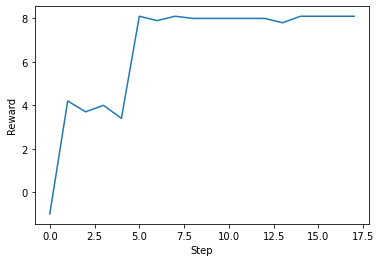

In [ ]:
plot_rewards(test_env_rewards)

### DQN on Atari Pong

Before running DQN on Pong, we need to define a few wrappers for the Gym environment. The PreproWrapper applies some preprocessing to the images, resizing them to 80x80 and making them greyscale. The MaxAndSkipEnv modifies our environment to take the max reward over a certain number of frames. This helps to stabilize training. We've implemented these for you and you do not need to modify them.


In [ ]:
def greyscale(state):
    """
    Preprocess state (210, 160, 3) image into
    a (80, 80, 1) image in grey scale
    """
    state = np.reshape(state, [210, 160, 3]).astype(np.float32)

    # grey scale
    state = state[:, :, 0] * 0.299 + state[:, :, 1] * 0.587 + state[:, :, 2] * 0.114

    # karpathy
    state = state[35:195]  # crop
    state = state[::2,::2] # downsample by factor of 2

    state = state[:, :, np.newaxis]

    return state.astype(np.uint8)

class MaxAndSkipEnv(gym.Wrapper):
    """
    Wrapper from Berkeley's Assignment
    Takes a max pool over the last n states
    """
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip       = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)

        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init. to first obs. from inner env."""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

class PreproWrapper(gym.Wrapper):
    """
    Wrapper for Pong to apply preprocessing
    Stores the state into variable self.obs
    """
    def __init__(self, env, prepro, shape, high=255):
        """
        Args:
            env: (gym env)
            prepro: (function) to apply to a state for preprocessing
            shape: (list) shape of obs after prepro
            grey_scale: (bool) if True, assume grey scale, else black and white
            high: (int) max value of state after prepro
        """
        super(PreproWrapper, self).__init__(env)
        self.prepro = prepro
        self.observation_space = spaces.Box(low=0, high=high, shape=shape, dtype=np.uint8)
        self.high = high


    def step(self, action):
        """
        Overwrites _step function from environment to apply preprocess
        """
        obs, reward, done, info = self.env.step(action)
        self.obs = self.prepro(obs)
        return self.obs, reward, done, info


    def reset(self):
        obs = self.env.reset()
        self.obs = self.prepro(obs)
        return self.obs

We're now ready to run Pong. This may take a few hours (~4 hours for our reference solution) to run, but you should start seeing improvements after an hour (ie. you will start seeing Average rewards > -21). If not, then there may be something wrong with your implementation.

The maximum reward here is 21 and you should see that as the Average reward at some point during training. Again, don't worry if the reward at your last iteration is not 21, as long as you hit 21 at some point during training.

In the video we show during training, the agent is the green paddle on the right.

In [ ]:
def run_pong():
    config = {
        'env_name': 'PongNoFrameskip-v4',
        'exp_name': 'dqn',
        'seed': 1,
      
        'num_episodes_test': 20,
        'eval_freq': 10000,
        'video': False,
        'video_freq': 10000,
      
        'batch_size': 32,
        'learning_start': 50000,
        'learning_freq': 4,
        'frame_history_len': 4,
        'skip_frame': 4,
      
        'target_update_freq': 10000,
        'nsteps_train': 2000000,
        'buffer_size': 1000000,
      
        'lr_begin': 0.00025,
        'lr_end': 0.00005,
        'lr_nsteps': 2000000//2,

        'eps_begin': 1,
        'eps_end': 0.1,
        'eps_nsteps': 2000000 * 0.1,
        'gamma': 0.99, # atari
      
        'grad_clip_value': 10,
      
        'obs_dtype': np.uint8,
        'q_net_func': create_q_network,
      
        'device': device
    }
    
    env = gym.make(config['env_name'])
    env = MaxAndSkipEnv(env, skip=config['skip_frame'])
    env = PreproWrapper(env, prepro=greyscale, shape=(84, 84, 1))
    dqn_agent, rewards = run(env, config)
    return dqn_agent, rewards, env
    
pong_dqn_agent, pong_rewards, pong_env = run_pong()

Starting...

Evaluating...
Average reward: -21.00 +/- 0.00
t:50295, n:65, exp:0.7773805, lr:0.0002401058, total_reward:-21.0, total_loss:17.482851028442383, eval_rewards:-21.0

Evaluating...
Average reward: -21.00 +/- 0.00
t:60712, n:78, exp:0.7313995, lr:0.0002380622, total_reward:-20.0, total_loss:2.228208303451538, eval_rewards:-21.0

Evaluating...
Average reward: -21.00 +/- 0.00
t:71234, n:91, exp:0.682885, lr:0.000235906, total_reward:-21.0, total_loss:1.0592896938323975, eval_rewards:-21.0

Evaluating...
Average reward: -21.00 +/- 0.00
t:81743, n:104, exp:0.6368095, lr:0.0002338582, total_reward:-21.0, total_loss:0.8265904188156128, eval_rewards:-21.0

Evaluating...
Average reward: -21.00 +/- 0.00
t:92493, n:117, exp:0.587845, lr:0.000231682, total_reward:-20.0, total_loss:0.9115360379219055, eval_rewards:-21.0

Evaluating...
Average reward: -21.00 +/- 0.00
t:103261, n:130, exp:0.5396635000000001, lr:0.00022954060000000002, total_reward:-20.0, total_loss:0.5992536544799805, eval_

Plot the rewards curve for the pong:

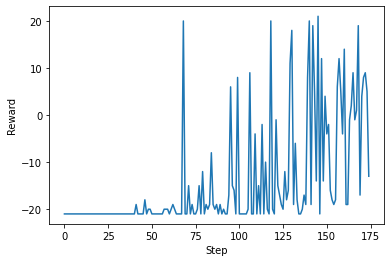

In [ ]:
plot_rewards(pong_rewards)